In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation
import matplotlib as mpl
font = {'size' : 12}
mpl.rc('font', **font)
%matplotlib widget
import cv2
import random
import trackpy as tp
import numpy as np
import pandas as pd
from scipy.spatial import KDTree, cKDTree, Voronoi, voronoi_plot_2d, ConvexHull
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import trackpy as tp
from yupi import Trajectory, WindowType, DiffMethod
import yupi.graphics as yg
import yupi.stats as ys
from yupi.transformations import subsample
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx 
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import graph_tool.all as gt
from analysis_utils import *
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import joblib
parallel = joblib.Parallel(n_jobs=4)


show_verb = False
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = True
save_verb = True
run_analysis_verb = True

In [2]:
video_selection = '49b1r' #'49b1r_post_merge'

if video_selection == '25b25r-1':
    nDrops             = 50
    xmin, ymin, xmax, ymax = 95, 30, 535, 470    
    pxDimension = 90/500 # 9cm is the petri dish --> 90mm
    red_particle_idx = np.sort(np.array([38, 42, 25, 4, 23, 13, 45, 33, 46, 29, 10, 3, 35, 18, 12, 0, 27, 19, 26, 47, 7, 48, 21, 20, 22], dtype=int))
    original_trajectories = pd.read_parquet('../tracking/25b25r-1/modified_2D_versatile_fluo/interpolated_tracking_25b25r-1_modified_2D_versatile_fluo_0_539999.parquet')
    original_trajectories.r = original_trajectories.r * pxDimension
    original_trajectories = original_trajectories.loc[:, ['x', 'y', 'r', 'frame', 'particle', 'color']]

elif video_selection == '49b1r':
    nDrops             = 50
    xmin, ymin, xmax, ymax = 20, 50, 900, 930
    pxDimension = 90/500 
    original_trajectories = pd.read_parquet('../tracking/49b1r/modified_2D_versatile_fluo/interpolated_tracking_49b1r_modified_2D_versatile_fluo_pre_merge.parquet')
    original_trajectories.r = original_trajectories.r * pxDimension
    original_trajectories = original_trajectories.loc[:, ['x', 'y', 'r', 'frame', 'particle', 'color']]
    red_particle_idx = np.array([19]).astype(int)

elif video_selection == '49b1r_post_merge':
    nDrops             = 49
    xmin, ymin, xmax, ymax = 20, 50, 900, 930
    pxDimension = 90/500 
    original_trajectories = pd.read_parquet('../tracking/49b1r/modified_2D_versatile_fluo/interpolated_tracking_49b1r_modified_2D_versatile_fluo_post_merge.parquet')
    original_trajectories.r = original_trajectories.r * pxDimension
    original_trajectories = original_trajectories.loc[:, ['x', 'y', 'r', 'frame', 'particle', 'color']]
    red_particle_idx = np.array([15]).astype(int)

path = trim_up_to_char(video_selection, '_')
source_path        = f'../tracking/data/{path}.mp4'
res_path           = f'./{video_selection}/results'
pdf_res_path       = f'../../thesis_project/images/{video_selection}'
analysis_data_path = f'./{video_selection}/analysis_data'
system_name        = f'{video_selection} system'


video = cv2.VideoCapture(source_path)
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
subsample_factor = int(fps/10)
n_frames_video = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'Video has {n_frames_video} frames with a resolution of {w}x{h} and a framerate of {fps} fps')

frames = original_trajectories.frame.unique().astype(int)
nFrames = len(frames)
print(f'Number of Droplets: {nDrops}')
print(f'Number of Frames: {nFrames} at {fps} fps --> {nFrames/fps:.2f} s')


maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds


red_mask = np.zeros(nDrops, dtype=bool)
red_mask[red_particle_idx] = True
colors = np.array(['b' for i in range(nDrops)])
colors[red_particle_idx] = 'r'

# ANALYSIS PARAMETERS

x_diffusive = np.linspace(10, maxLagtime/fps, int((maxLagtime/fps + 1/fps - 10)*fps)) 
x_ballistic = np.linspace(1/fps, 1, int((1-1/fps)*fps)+1)

speed_units = 'mm/s'
dimension_units = 'mm'
default_kwargs_blue = {'color': '#00FFFF', 'ec': (0, 0, 0, 0.6), 'density': True}
default_kwargs_red = {'color': '#EE4B2B', 'ec': (0, 0, 0, 0.6), 'density': True}

if 1:
    trajectories = get_smooth_trajs(original_trajectories, nDrops, int(fps/2), 4)
else:
    trajectories = original_trajectories

Video has 80794 frames with a resolution of 920x960 and a framerate of 10 fps
Number of Droplets: 50
Number of Frames: 32269 at 10 fps --> 3226.90 s


In [3]:
@joblib.delayed
def run_windowed_analysis(wind):
    window = wind*fps # 300 s
    stride = 10*fps # 10 s
    startFrames = np.arange(frames[0], nFrames-window, stride, dtype=int)
    endFrames = startFrames + window
    nSteps = len(startFrames)
    EMSD_wind_b_list, EMSD_wind_r_list, fit_wind_list = [], [], []
    # MSD
    if 1:
        MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nDrops, nSteps, startFrames, endFrames, trajectories, pxDimension, fps, maxLagtime, x_diffusive)
        EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x_diffusive, fps, red_mask, nSteps, maxLagtime, x_diffusive)
    
    # TURNING ANGLES
    if 1:
        theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, subsample_factor, fps)

        # fit windowed turning angles distributions with lorentzian distribution
        blue_fit_wind_turn_lorentzian = np.ones((nSteps, 2, 2))
        red_fit_wind_turn_lorentzian = np.ones((nSteps, 2, 2))
        for k in range(nSteps):
            blue_fit_wind_turn_lorentzian[k, 0], blue_fit_wind_turn_lorentzian[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, lorentzian_distr, [1., 0.])
            red_fit_wind_turn_lorentzian[k, 0], red_fit_wind_turn_lorentzian[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, lorentzian_distr, [1., 0.])

    return startFrames, EMSD_wind_b, EMSD_wind_r, fit_dict, blue_fit_wind_turn_lorentzian, red_fit_wind_turn_lorentzian

In [34]:
windLen = [110, 300, 600, 900, 1200, 1500, 1800, 2100]
bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

startFrames_list, EMSD_wind_b_list, EMSD_wind_r_list, fit_dict_list, blue_fit_wind_turn_lorentzian_list, red_fit_wind_turn_lorentzian_list = zip(*parallel(run_windowed_analysis(wind) for wind in windLen))

100%|██████████| 173/173 [00:30<00:00,  5.68it/s]


In [35]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
if 0:
    number_of_colors = len(windLen)
    random.seed(42)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                for i in range(number_of_colors)]
    print(colors)

In [52]:
fit_dict_list[i].keys()

dict_keys(['fit_wind_b', 'pw_exp_wind_b', 'fit_wind_r', 'pw_exp_wind_r'])

In [66]:
pw_exp_bins = np.linspace(0, 2, 100)
d_bins = np.linspace(0, 200, 100)

gamma_bins = np.linspace(0.2, 1, 100)

count_alpha_b = np.zeros((len(windLen), len(pw_exp_bins)-1))
count_alpha_r = np.zeros((len(windLen), len(pw_exp_bins)-1))
count_d_b = np.zeros((len(windLen), len(d_bins)-1))
count_d_r = np.zeros((len(windLen), len(d_bins2)-1))
count_gamma_b = np.zeros((len(windLen), len(gamma_bins)-1))
count_gamma_r = np.zeros((len(windLen), len(gamma_bins)-1))
for i in range(len(windLen)):
    count_alpha_b[i], _ =  np.histogram(fit_dict_list[i]['pw_exp_wind_b'][:, 0, 1], bins=pw_exp_bins, density=True)
    count_alpha_r[i], _ =  np.histogram(fit_dict_list[i]['pw_exp_wind_r'][:, 0, 1], bins=pw_exp_bins, density=True)
    count_d_b[i], _     = np.histogram(fit_dict_list[i]['pw_exp_wind_b'][:, 0, 0], bins=d_bins, density=True)
    count_d_r[i], _     = np.histogram(fit_dict_list[i]['pw_exp_wind_r'][:, 0, 0], bins=d_bins, density=True)
    count_gamma_b[i], _ = np.histogram(blue_fit_wind_turn_lorentzian_list[i][:, 0, 0], bins=gamma_bins, density=True)
    count_gamma_r[i], _ = np.histogram(red_fit_wind_turn_lorentzian_list[i][:, 0, 0], bins=gamma_bins, density=True)

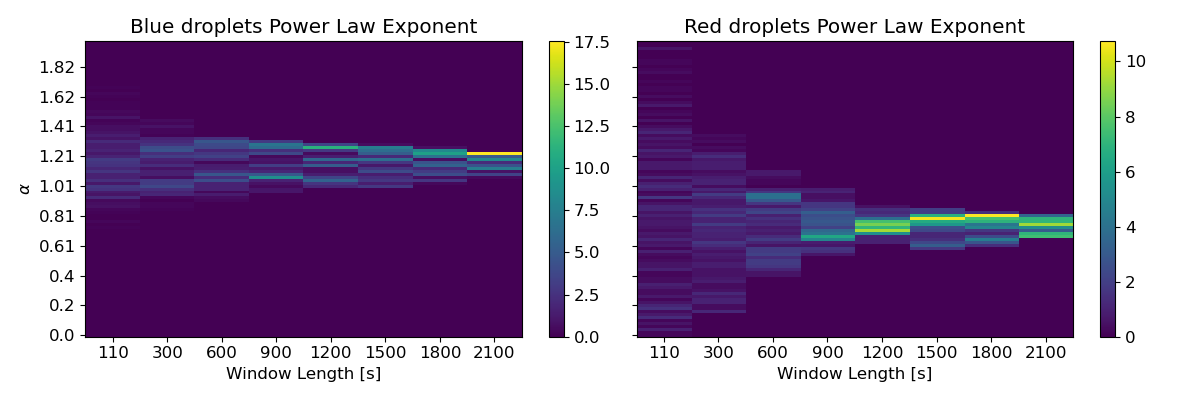

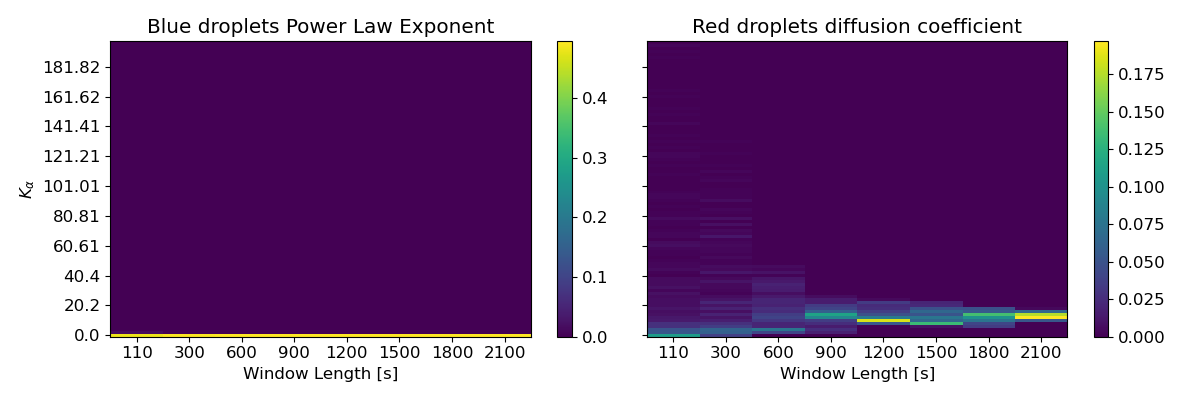

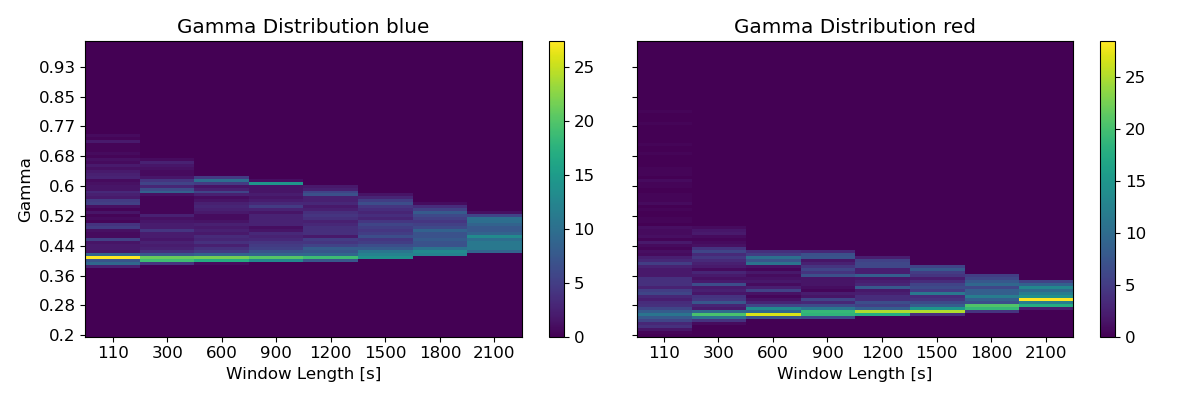

In [67]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
img = ax.imshow(count_alpha_b.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax.set_xlabel('Window Length [s]')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Blue droplets Power Law Exponent')
ax.set_yticks(np.arange(len(pw_exp_bins))[::10])
ax.set_yticklabels(np.round(pw_exp_bins[::10], 2))
ax.set_xticks(range(len(windLen)))
ax.set_xticklabels(windLen)
plt.colorbar(img, ax = ax)

img = ax1.imshow(count_alpha_r.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax1.set_xlabel('Window Length [s]')
ax1.set_title('Red droplets Power Law Exponent')
ax1.set_yticks(np.arange(len(pw_exp_bins))[::10])
ax1.set_yticklabels(np.round(pw_exp_bins[::10], 2))
ax1.set_xticks(range(len(windLen)))
ax1.set_xticklabels(windLen)
plt.colorbar(img, ax = ax1)
plt.tight_layout()
plt.savefig(f'{res_path}/window_lenght_analysis/pw_exp_windowed.pdf')
plt.show()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
img = ax.imshow(count_d_b.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax.set_xlabel('Window Length [s]')
ax.set_ylabel(r'$K_\alpha$')
ax.set_title('Blue droplets Power Law Exponent')
ax.set_yticks(np.arange(len(d_bins))[::10])
ax.set_yticklabels(np.round(d_bins[::10], 2))
ax.set_xticks(range(len(windLen)))
ax.set_xticklabels(windLen)
plt.colorbar(img, ax = ax)

img = ax1.imshow(count_d_r.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax1.set_xlabel('Window Length [s]')
ax1.set_title('Red droplets diffusion coefficient')
ax1.set_yticks(np.arange(len(d_bins))[::10])
ax1.set_yticklabels(np.round(d_bins[::10], 2))
ax1.set_xticks(range(len(windLen)))
ax1.set_xticklabels(windLen)
plt.colorbar(img, ax = ax1)
plt.tight_layout()
plt.savefig(f'{res_path}/window_lenght_analysis/diff_coeff_windowed.pdf')
plt.show()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
img = ax.imshow(count_gamma_b.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax.set_xlabel('Window Length [s]')
ax.set_ylabel('Gamma')
ax.set_title('Gamma Distribution blue')
ax.set_yticks(np.arange(len(gamma_bins))[::10])
ax.set_yticklabels(np.round(gamma_bins[::10], 2))
ax.set_xticks(range(len(windLen)))
ax.set_xticklabels(windLen)
plt.colorbar(img, ax = ax)

img = ax1.imshow(count_gamma_r.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax1.set_xlabel('Window Length [s]')
ax1.set_title('Gamma Distribution red')
ax1.set_yticks(np.arange(len(gamma_bins))[::10])
ax1.set_yticklabels(np.round(gamma_bins[::10], 2))
ax1.set_xticks(range(len(windLen)))
ax1.set_xticklabels(windLen)
plt.colorbar(img, ax = ax1)
plt.tight_layout()
plt.savefig(f'{res_path}/window_lenght_analysis/turn_angles_windowed.pdf')
plt.show()

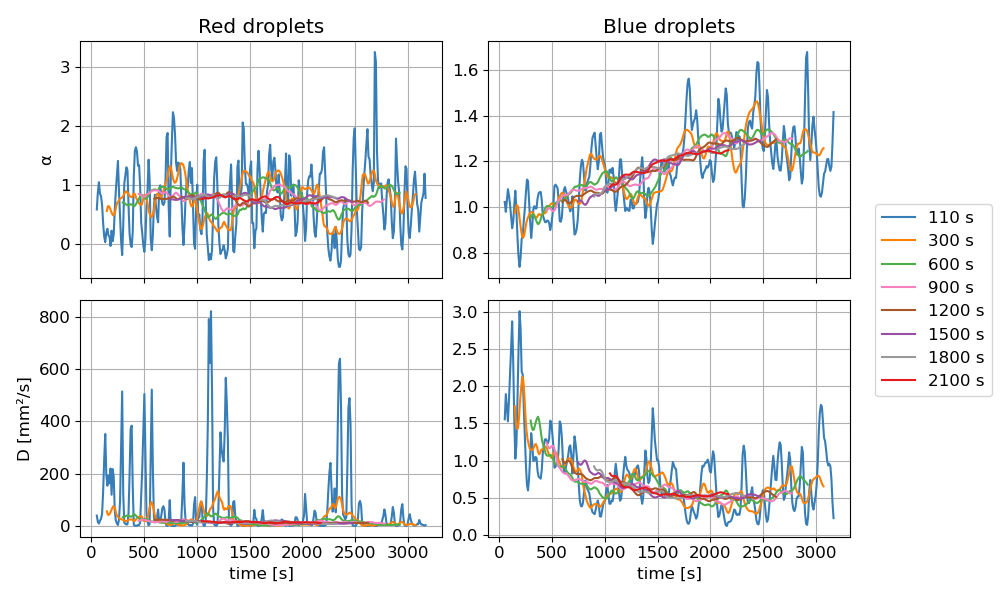

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)    
for i, wind in enumerate(windLen):
    alpha_r = fit_dict_list[i]['pw_exp_wind_r'][:, 0, 1]
    alpha_b = fit_dict_list[i]['pw_exp_wind_b'][:, 0, 1]
    D_r = fit_dict_list[i]['pw_exp_wind_r'][:, 0, 0]
    D_b = fit_dict_list[i]['pw_exp_wind_b'][:, 0, 0]
    ax[0, 0].plot((startFrames_list[i] + wind*fps/2)/fps, alpha_r, label=f'{windLen[i]} s', color=colors[i])
    ax[0, 1].plot((startFrames_list[i] + wind*fps/2)/fps, alpha_b, color=colors[i])
    ax[1, 0].plot((startFrames_list[i] + wind*fps/2)/fps, D_r, color=colors[i])
    ax[1, 1].plot((startFrames_list[i] + wind*fps/2)/fps, D_b, color=colors[i])
ax[0, 0].set(ylabel = 'α', title='Red droplets')
ax[0, 0].grid()
ax[0, 1].set( title='Blue droplets')
ax[0, 1].grid()
ax[1, 0].set(ylabel = 'D [mm²/s]', xlabel='time [s]')
ax[1, 0].set(xlabel = 'time [s]')
ax[1, 0].grid()
ax[1, 1].set(xlabel = 'time [s]')
ax[1, 1].grid()
plt.tight_layout()
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.savefig(f'./{res_path}/windowed_analysis_emsd.pdf')
plt.show()

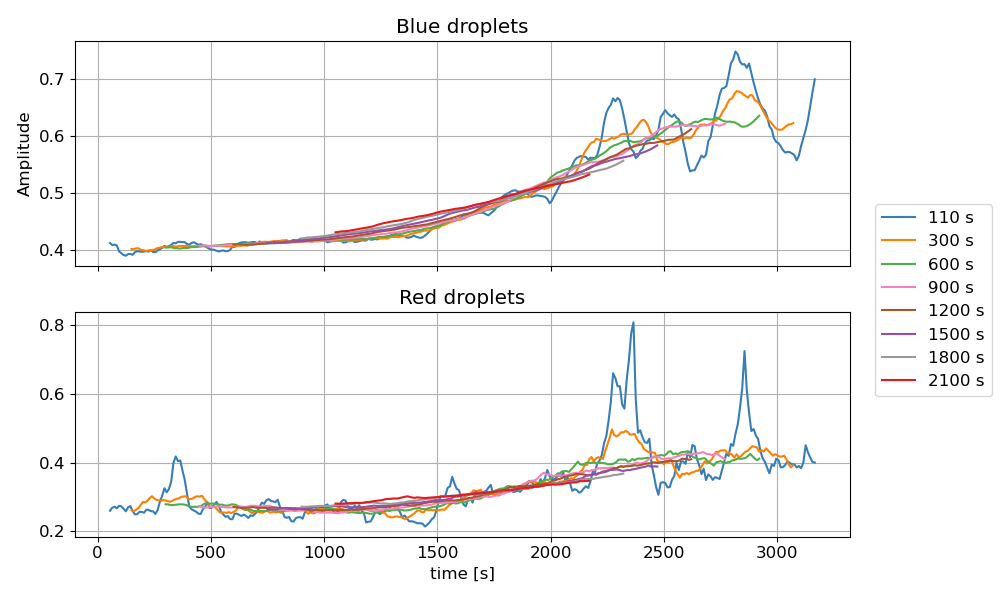

In [50]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)    
for i, wind in enumerate(windLen):
    ax.plot((startFrames_list[i] + wind*fps/2)/fps, blue_fit_wind_turn_lorentzian_list[i][:, 0, 0], label=f'{windLen[i]} s', color=colors[i])
    ax1.plot((startFrames_list[i] + wind*fps/2)/fps, red_fit_wind_turn_lorentzian_list[i][:, 0, 0], color=colors[i])
ax.set(ylabel = 'Amplitude', title='Blue droplets')
ax.grid()
ax1.set( title='Red droplets')
ax1.grid()
ax1.set(xlabel = 'time [s]')
plt.tight_layout()
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.savefig(f'./{res_path}/windowed_analysis_turning_angles.pdf')
plt.show()